<a href="https://colab.research.google.com/github/agmCorp/colab/blob/main/matching_catalogos_bse_autodata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Matching Inteligente: BSE vs Autodata
## Solución basada en Embeddings Semánticos (Sentence-BERT)

**Objetivo:** Identificar automáticamente qué modelos de Autodata ya existen en el catálogo BSE

**Criterios de clasificación:**
- **YA EXISTE** → score > 0.75
- **REVISIÓN HUMANA** → 0.6 ≤ score ≤ 0.75
- **ALTA NECESARIA** → score < 0.6

---

## 1️⃣ Instalación de dependencias

In [1]:
# Instalar librerías necesarias
!pip install -q sentence-transformers pandas numpy scikit-learn unidecode tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 18.8 MB/s eta 0:00:00


## 2️⃣ Importar librerías

In [15]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util
from unidecode import unidecode
import re
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

print("Librerías importadas correctamente")

Librerías importadas correctamente


## 3️⃣ Cargar los archivos CSV

**Importante:** Sube los archivos en la sección de archivos de Colab:
- `CART_MATRICERO_BSE_202602031858.csv`
- `CART_PAD_AUTODATA_202602031856.csv`

In [16]:
# Cargar los datos
df_bse = pd.read_csv('/content/sample_data/CART_MATRICERO_BSE_202602031858.csv')
df_autodata = pd.read_csv('/content/sample_data/CART_PAD_AUTODATA_202602031856.csv')

print(f"Registros BSE: {len(df_bse):,}")
print(f"Registros Autodata: {len(df_autodata):,}")
print("\nPrimeras filas de BSE:")
display(df_bse.head(3))
print("\nPrimeras filas de Autodata:")
display(df_autodata.head(3))

Registros BSE: 32,945
Registros Autodata: 19,847

Primeras filas de BSE:


,MARCA,RANGO_ANIOS,MODELO,ID_AUTODATA_BSE
0,NISSAN,2025 - 2025,"FRONTIER NEW 2.5 LE 187HP TDSL DC E.Full,CLIM,...",6.804822e+09
1,NISSAN,2025 - 2025,"FRONTIER NEW 2.5 LE 187HP TDSL DC E.Full,CLIM,...",6.804822e+09
2,NISSAN,2025 - 2025,"FRONTIER NEW 2.5 LE TDSL DC E.FULL,CLIM,CUE,AY...",6.804842e+09



Primeras filas de Autodata:


,ID_AUTADATA,MARCA_A,MODELO_A,ANIO_A
0,2500121998,DAEWOO<COR>,Damas Coach 7 asientos Caja de 4ta.,1998
1,2501051998,DAEWOO<COR>,Damas Van Furg¿n c/diesel adaptado,1998
2,2501121998,DAEWOO<COR>,Damas Van Furgon adaptada a rural,1998


## 4️⃣ Funciones de Preprocesamiento

In [17]:
def normalizar_texto(texto):
    """
    Normaliza texto removiendo acentos, convirtiendo a minúsculas,
    y eliminando caracteres especiales excepto espacios y números.
    """
    if pd.isna(texto):
        return ""
    # Convertir a string y minúsculas
    texto = str(texto).lower()
    # Remover acentos
    texto = unidecode(texto)
    # Remover caracteres especiales pero mantener espacios y números
    texto = re.sub(r'[^a-z0-9\s]', ' ', texto)
    # Normalizar espacios múltiples
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto


def normalizar_marca(marca):
    """
    Normaliza marcas removiendo sufijos como <BRA>, <COR>, etc.
    y estandarizando variantes comunes.
    """
    marca_norm = normalizar_texto(marca)
    # Remover sufijos entre <>
    marca_norm = re.sub(r'<[^>]+>', '', marca_norm).strip()

    # Diccionario de variantes comunes
    variantes = {
        'volkswagen': 'vw',
        'mercedes benz': 'mercedes',
        'land rover': 'landrover',
        'chevrolet': 'chevy',
    }

    for original, abrev in variantes.items():
        if original in marca_norm:
            marca_norm = abrev

    return marca_norm


def extraer_anio_inicio_fin(rango_anios):
    """
    Extrae año de inicio y fin de un rango como "2020 - 2023"
    Retorna (año_inicio, año_fin)
    """
    if pd.isna(rango_anios):
        return None, None

    rango_str = str(rango_anios).strip()
    # Buscar patrones como "2020 - 2023" o "2020-2023"
    match = re.search(r'(\d{4})\s*-\s*(\d{4})', rango_str)
    if match:
        return int(match.group(1)), int(match.group(2))

    # Si es un año suelto
    match = re.search(r'(\d{4})', rango_str)
    if match:
        anio = int(match.group(1))
        return anio, anio

    return None, None


def anio_en_rango(anio_puntual, anio_inicio, anio_fin):
    """
    Verifica si un año puntual está dentro de un rango.
    """
    if anio_inicio is None or anio_fin is None or anio_puntual is None:
        return False
    return anio_inicio <= anio_puntual <= anio_fin


print("Funciones de preprocesamiento definidas")

Funciones de preprocesamiento definidas


## 5️⃣ Preprocesamiento de datos

In [18]:
# Preprocesar BSE
df_bse['marca_norm'] = df_bse['MARCA'].apply(normalizar_marca)
df_bse['modelo_norm'] = df_bse['MODELO'].apply(normalizar_texto)
df_bse[['anio_inicio', 'anio_fin']] = df_bse['RANGO_ANIOS'].apply(
    lambda x: pd.Series(extraer_anio_inicio_fin(x))
)

# Preprocesar Autodata
df_autodata['marca_norm'] = df_autodata['MARCA_A'].apply(normalizar_marca)
df_autodata['modelo_norm'] = df_autodata['MODELO_A'].apply(normalizar_texto)
df_autodata['anio'] = df_autodata['ANIO_A'].astype(int)

print("Datos preprocesados")
print(f"\nBSE válidos (con años): {df_bse[df_bse['anio_inicio'].notna()].shape[0]:,}")
print(f"Autodata válidos: {len(df_autodata):,}")

# Eliminar registros sin información de años en BSE
df_bse = df_bse[df_bse['anio_inicio'].notna()].copy()

print("\nEjemplo de preprocesamiento:")
print("\nBSE:")
display(df_bse[['MARCA', 'marca_norm', 'MODELO', 'modelo_norm', 'RANGO_ANIOS', 'anio_inicio', 'anio_fin']].head(3))
print("\nAutodata:")
display(df_autodata[['MARCA_A', 'marca_norm', 'MODELO_A', 'modelo_norm', 'ANIO_A', 'anio']].head(3))

Datos preprocesados

BSE válidos (con años): 32,945
Autodata válidos: 19,847

Ejemplo de preprocesamiento:

BSE:


,MARCA,marca_norm,MODELO,modelo_norm,RANGO_ANIOS,anio_inicio,anio_fin
0,NISSAN,nissan,"FRONTIER NEW 2.5 LE 187HP TDSL DC E.Full,CLIM,...",frontier new 2 5 le 187hp tdsl dc e full clim ...,2025 - 2025,2025,2025
1,NISSAN,nissan,"FRONTIER NEW 2.5 LE 187HP TDSL DC E.Full,CLIM,...",frontier new 2 5 le 187hp tdsl dc e full clim ...,2025 - 2025,2025,2025
2,NISSAN,nissan,"FRONTIER NEW 2.5 LE TDSL DC E.FULL,CLIM,CUE,AY...",frontier new 2 5 le tdsl dc e full clim cue ay...,2025 - 2025,2025,2025



Autodata:


,MARCA_A,marca_norm,MODELO_A,modelo_norm,ANIO_A,anio
0,DAEWOO<COR>,daewoo cor,Damas Coach 7 asientos Caja de 4ta.,damas coach 7 asientos caja de 4ta,1998,1998
1,DAEWOO<COR>,daewoo cor,Damas Van Furg¿n c/diesel adaptado,damas van furg n c diesel adaptado,1998,1998
2,DAEWOO<COR>,daewoo cor,Damas Van Furgon adaptada a rural,damas van furgon adaptada a rural,1998,1998


## 6️⃣ Cargar modelo de Sentence-BERT

Usaremos **paraphrase-multilingual-MiniLM-L12-v2** que:
- Soporta español
- Es rápido (384 dimensiones)
- Captura similitud semántica efectivamente

In [19]:
# Cargar modelo de embeddings
print("Cargando modelo Sentence-BERT...")
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
print("Modelo cargado exitosamente")

Cargando modelo Sentence-BERT...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Modelo cargado exitosamente


## 7️⃣ Generar embeddings para BSE (una sola vez)

In [20]:
# Generar embeddings para todos los modelos de BSE
print("Generando embeddings para catálogo BSE...")
print(f"Total de modelos: {len(df_bse):,}")

# Crear texto combinado para mejor contexto
df_bse['texto_embedding'] = df_bse['marca_norm'] + ' ' + df_bse['modelo_norm']

# Generar embeddings en lotes para eficiencia
batch_size = 128
bse_embeddings = model.encode(
    df_bse['texto_embedding'].tolist(),
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_tensor=False
)

print(f"\nEmbeddings generados: {bse_embeddings.shape}")
print(f"Dimensiones: {bse_embeddings.shape[1]}")

Generando embeddings para catálogo BSE...
Total de modelos: 32,945


Batches:   0%|          | 0/258 [00:00<?, ?it/s]


Embeddings generados: (32945, 384)
Dimensiones: 384


## 8️⃣ Función principal de matching

In [21]:
def encontrar_matches(row_autodata, df_bse, bse_embeddings, model, top_k=3):
    """
    Encuentra los mejores matches para un registro de Autodata.

    Retorna:
    - Lista de diccionarios con top_k candidatos
    - Cada candidato incluye: ID_AUTODATA_BSE, score, marca, modelo, rango
    """
    marca_auto = row_autodata['marca_norm']
    anio_auto = row_autodata['anio']
    modelo_auto = row_autodata['modelo_norm']

    # PASO 1: Filtrar por marca exacta (o muy similar)
    mask_marca = df_bse['marca_norm'] == marca_auto

    # Si no hay coincidencias exactas, buscar marcas similares
    if mask_marca.sum() == 0:
        # Buscar marcas que contengan la marca buscada o viceversa
        mask_marca = df_bse['marca_norm'].apply(
            lambda x: marca_auto in x or x in marca_auto
        )

    # PASO 2: Filtrar por año dentro del rango
    mask_anio = df_bse.apply(
        lambda x: anio_en_rango(anio_auto, x['anio_inicio'], x['anio_fin']),
        axis=1
    )

    # Combinar filtros
    mask_candidatos = mask_marca & mask_anio

    # Si no hay candidatos con marca Y año, relajar a solo marca
    if mask_candidatos.sum() == 0:
        mask_candidatos = mask_marca

    # Si aún no hay candidatos, retornar sin matches
    if mask_candidatos.sum() == 0:
        return []

    # PASO 3: Calcular similitud semántica solo con candidatos filtrados
    indices_candidatos = df_bse[mask_candidatos].index.tolist()
    embeddings_candidatos = bse_embeddings[indices_candidatos]

    # Generar embedding para el modelo de Autodata
    texto_autodata = marca_auto + ' ' + modelo_auto
    embedding_autodata = model.encode(texto_autodata, convert_to_tensor=False)

    # Calcular similitud coseno
    similitudes = util.cos_sim(embedding_autodata, embeddings_candidatos)[0].numpy()

    # PASO 4: Aplicar bonificación por coincidencia exacta de marca y año
    scores_ajustados = []
    for i, idx_bse in enumerate(indices_candidatos):
        score_base = float(similitudes[i])

        # Bonificación por marca exacta
        if df_bse.loc[idx_bse, 'marca_norm'] == marca_auto:
            score_base *= 1.05  # +5%

        # Bonificación por año en rango
        if anio_en_rango(anio_auto, df_bse.loc[idx_bse, 'anio_inicio'],
                        df_bse.loc[idx_bse, 'anio_fin']):
            score_base *= 1.10  # +10%

        # Normalizar a máximo 1.0
        score_final = min(score_base, 1.0)
        scores_ajustados.append(score_final)

    # PASO 5: Ordenar y seleccionar top K
    top_indices = np.argsort(scores_ajustados)[::-1][:top_k]

    resultados = []
    for i in top_indices:
        idx_bse = indices_candidatos[i]
        score = scores_ajustados[i]

        resultados.append({
            'ID_AUTODATA_BSE': df_bse.loc[idx_bse, 'ID_AUTODATA_BSE'],
            'score': score,
            'marca_bse': df_bse.loc[idx_bse, 'MARCA'],
            'modelo_bse': df_bse.loc[idx_bse, 'MODELO'],
            'rango_anios_bse': df_bse.loc[idx_bse, 'RANGO_ANIOS']
        })

    return resultados


def clasificar_resultado(score, umbral_existe=0.75, umbral_alta=0.60):
    """
    Clasifica el resultado basado en el score y umbrales.
    """
    if score >= umbral_existe:
        return 'YA_EXISTE'
    elif score < umbral_alta:
        return 'ALTA_NECESARIA'
    else:
        return 'REVISION_HUMANA'


print("Funciones de matching definidas")

Funciones de matching definidas


## 9️⃣ Ejecutar matching para todo el catálogo Autodata

**NOTA:** Este proceso puede tomar varios minutos dependiendo del tamaño del catálogo. Usar GPU.

In [9]:
# Parámetros de clasificación
UMBRAL_EXISTE = 0.75
UMBRAL_ALTA = 0.60
TOP_K = 3

print("Iniciando proceso de matching...")
print(f"Umbrales: YA_EXISTE > {UMBRAL_EXISTE}, ALTA_NECESARIA < {UMBRAL_ALTA}")
print(f"Candidatos por registro: Top {TOP_K}\n")

# Lista para almacenar resultados
resultados_finales = []

# Procesar cada registro de Autodata
for idx, row in tqdm(df_autodata.iterrows(), total=len(df_autodata), desc="Procesando"):
    # Encontrar matches
    matches = encontrar_matches(row, df_bse, bse_embeddings, model, top_k=TOP_K)

    # Preparar resultado para este registro
    if len(matches) == 0:
        # Sin candidatos
        resultado = {
            'ID_AUTADATA': row['ID_AUTADATA'],
            'MARCA_A': row['MARCA_A'],
            'MODELO_A': row['MODELO_A'],
            'ANIO_A': row['ANIO_A'],
            'DECISION': 'ALTA_NECESARIA',
            'SCORE_MEJOR': 0.0,
            'ID_AUTODATA_BSE_MEJOR': None,
            'MARCA_BSE_MEJOR': None,
            'MODELO_BSE_MEJOR': None,
            'RANGO_ANIOS_BSE_MEJOR': None,
        }

        # Candidatos alternos (vacíos)
        for i in range(1, TOP_K):
            resultado[f'SCORE_CANDIDATO_{i+1}'] = None
            resultado[f'ID_AUTODATA_BSE_CANDIDATO_{i+1}'] = None
            resultado[f'MODELO_BSE_CANDIDATO_{i+1}'] = None

    else:
        # Hay candidatos - tomar el mejor
        mejor_match = matches[0]
        decision = clasificar_resultado(mejor_match['score'], UMBRAL_EXISTE, UMBRAL_ALTA)

        resultado = {
            'ID_AUTADATA': row['ID_AUTADATA'],
            'MARCA_A': row['MARCA_A'],
            'MODELO_A': row['MODELO_A'],
            'ANIO_A': row['ANIO_A'],
            'DECISION': decision,
            'SCORE_MEJOR': round(mejor_match['score'], 4),
            'ID_AUTODATA_BSE_MEJOR': mejor_match['ID_AUTODATA_BSE'],
            'MARCA_BSE_MEJOR': mejor_match['marca_bse'],
            'MODELO_BSE_MEJOR': mejor_match['modelo_bse'],
            'RANGO_ANIOS_BSE_MEJOR': mejor_match['rango_anios_bse'],
        }

        # Añadir candidatos alternos
        for i in range(1, TOP_K):
            if i < len(matches):
                resultado[f'SCORE_CANDIDATO_{i+1}'] = round(matches[i]['score'], 4)
                resultado[f'ID_AUTODATA_BSE_CANDIDATO_{i+1}'] = matches[i]['ID_AUTODATA_BSE']
                resultado[f'MODELO_BSE_CANDIDATO_{i+1}'] = matches[i]['modelo_bse']
            else:
                resultado[f'SCORE_CANDIDATO_{i+1}'] = None
                resultado[f'ID_AUTODATA_BSE_CANDIDATO_{i+1}'] = None
                resultado[f'MODELO_BSE_CANDIDATO_{i+1}'] = None

    resultados_finales.append(resultado)

# Convertir a DataFrame
df_resultados = pd.DataFrame(resultados_finales)

print("\nMatching completado!")

🚀 Iniciando proceso de matching...
   Umbrales: YA_EXISTE > 0.75, ALTA_NECESARIA < 0.6
   Candidatos por registro: Top 3



Procesando:   0%|          | 0/19847 [00:00<?, ?it/s]


✅ Matching completado!


## 🔟 Análisis de Resultados

In [22]:
# Resumen estadístico
print("="*70)
print("RESUMEN DE RESULTADOS")
print("="*70)

decisiones_conteo = df_resultados['DECISION'].value_counts()
total = len(df_resultados)

print(f"\nTotal de registros procesados: {total:,}\n")

for decision, count in decisiones_conteo.items():
    porcentaje = (count / total) * 100
    simbolo = {'YA_EXISTE': '✅', 'ALTA_NECESARIA': '🆕', 'REVISION_HUMANA': '⚠️'}.get(decision, '❓')
    print(f"{simbolo} {decision:20s}: {count:6,} ({porcentaje:5.2f}%)")

# Distribución de scores
print("\n" + "="*70)
print("DISTRIBUCIÓN DE SCORES")
print("="*70)

scores = df_resultados['SCORE_MEJOR'].dropna()
if len(scores) > 0:
    print(f"\nEstadísticas de similitud:")
    print(f"Media:    {scores.mean():.4f}")
    print(f"Mediana:  {scores.median():.4f}")
    print(f"Desv.Std: {scores.std():.4f}")
    print(f"Mínimo:   {scores.min():.4f}")
    print(f"Máximo:   {scores.max():.4f}")

    # Percentiles
    print(f"\nPercentil 25: {scores.quantile(0.25):.4f}")
    print(f"Percentil 50: {scores.quantile(0.50):.4f}")
    print(f"Percentil 75: {scores.quantile(0.75):.4f}")
    print(f"Percentil 90: {scores.quantile(0.90):.4f}")

print("\n" + "="*70)

RESUMEN DE RESULTADOS

Total de registros procesados: 19,847

✅ YA_EXISTE           : 16,490 (83.09%)
⚠️ REVISION_HUMANA     :  1,797 ( 9.05%)
🆕 ALTA_NECESARIA      :  1,560 ( 7.86%)

DISTRIBUCIÓN DE SCORES

Estadísticas de similitud:
Media:    0.8377
Mediana:  0.9063
Desv.Std: 0.2301
Mínimo:   0.0000
Máximo:   1.0000

Percentil 25: 0.8061
Percentil 50: 0.9063
Percentil 75: 0.9753
Percentil 90: 1.0000



## 1️⃣1️⃣ Ejemplos de cada categoría

In [23]:
# Mostrar ejemplos de YA_EXISTE
print("="*100)
print("EJEMPLOS DE 'YA EXISTE' (score > 0.75)")
print("="*100)

ya_existe = df_resultados[df_resultados['DECISION'] == 'YA_EXISTE'].sort_values('SCORE_MEJOR', ascending=False).head(5)
if len(ya_existe) > 0:
    for idx, row in ya_existe.iterrows():
        print(f"\nScore: {row['SCORE_MEJOR']:.4f}")
        print(f"Autodata: {row['MARCA_A']} | {row['MODELO_A']} | {row['ANIO_A']}")
        print(f"BSE:      {row['MARCA_BSE_MEJOR']} | {row['MODELO_BSE_MEJOR']} | {row['RANGO_ANIOS_BSE_MEJOR']}")
        print(f"IDs: {row['ID_AUTADATA']} ↔ {row['ID_AUTODATA_BSE_MEJOR']}")
else:
    print("   No hay registros en esta categoría")

# Mostrar ejemplos de REVISION_HUMANA
print("\n" + "="*100)
print("EJEMPLOS DE 'REVISIÓN HUMANA' (0.60 ≤ score ≤ 0.75)")
print("="*100)

revision = df_resultados[df_resultados['DECISION'] == 'REVISION_HUMANA'].sort_values('SCORE_MEJOR', ascending=False).head(5)
if len(revision) > 0:
    for idx, row in revision.iterrows():
        print(f"\nScore: {row['SCORE_MEJOR']:.4f}")
        print(f"Autodata: {row['MARCA_A']} | {row['MODELO_A']} | {row['ANIO_A']}")
        print(f"Mejor:    {row['MARCA_BSE_MEJOR']} | {row['MODELO_BSE_MEJOR']} | {row['RANGO_ANIOS_BSE_MEJOR']}")

        # Mostrar candidatos alternos
        if pd.notna(row['SCORE_CANDIDATO_2']):
            print(f"Alt. 2:   Score {row['SCORE_CANDIDATO_2']:.4f} | {row['MODELO_BSE_CANDIDATO_2']}")
        if pd.notna(row['SCORE_CANDIDATO_3']):
            print(f"Alt. 3:   Score {row['SCORE_CANDIDATO_3']:.4f} | {row['MODELO_BSE_CANDIDATO_3']}")
else:
    print("   No hay registros en esta categoría")

# Mostrar ejemplos de ALTA_NECESARIA
print("\n" + "="*100)
print("EJEMPLOS DE 'ALTA NECESARIA' (score < 0.60)")
print("="*100)

alta = df_resultados[df_resultados['DECISION'] == 'ALTA_NECESARIA'].head(5)
if len(alta) > 0:
    for idx, row in alta.iterrows():
        print(f"\nScore: {row['SCORE_MEJOR']:.4f}")
        print(f"Autodata: {row['MARCA_A']} | {row['MODELO_A']} | {row['ANIO_A']}")
        if pd.notna(row['MODELO_BSE_MEJOR']):
            print(f"Mejor (no confiable): {row['MODELO_BSE_MEJOR']}")
        else:
            print(f"Sin candidatos encontrados")
else:
    print("No hay registros en esta categoría")

EJEMPLOS DE 'YA EXISTE' (score > 0.75)

Score: 1.0000
Autodata: MERCEDES BENZ    <ALE> | C 200 BlueEfficiency Elegance Aut. (W 204) | 2013
BSE:      MERCEDES BENZ | 200 A BLUEEFFICIENCY STYLE AUT (W176) | 2013 - 2013
IDs: 6109612013 ↔ 6110072013.0

Score: 1.0000
Autodata: MERCEDES BENZ    <ALE> | GLK 220 CDi Diesel 4x4 Extra Full Aut. (X 204) | 2013
BSE:      MERCEDES BENZ | 220 GLK CDI DIESEL 4X4 EXTRA FULL AUT. (X 204) DIESEL  | 2013 - 2013
IDs: 6111672013 ↔ 6111672011.0

Score: 1.0000
Autodata: LIFAN     <CHI> | 320 1.3 Full, ABS, 2Abag 5p. | 2017
BSE:      LIFAN | 330 1.3 FULL, ABS, 2ABAG 5P. | 2017 - 2017
IDs: 16400082017 ↔ 16400312017.0

Score: 1.0000
Autodata: HYUNDAI<COR> | New HB20X Cross 1.6 Premium, 4Abag,CES,CTR,Ay.Est. 5p (BRA) | 2020
BSE:      HYUNDAI | HB20 NEW 1.6 PREMIUM E.FULL,4ABAG,CES,CTR,AY.EST. 4-5P.(BRA) | 2020 - 2020
IDs: 4006162020 ↔ 4005982020.0

Score: 1.0000
Autodata: HYUNDAI<COR> | H1 Grand Starex Furgon 2.5 VGT Diesel Full,2Abag,ABS,c.est. | 2021
BSE:     

## 1️⃣2️⃣ Exportar resultados a CSV

In [24]:
# Exportar resultados completos
archivo_salida = 'resultados_matching_bse_autodata.csv'
df_resultados.to_csv(archivo_salida, index=False, encoding='utf-8-sig')

print(f"Resultados exportados a: {archivo_salida}")
print(f"Total de registros: {len(df_resultados):,}")

# Exportar solo registros para revisión humana
archivo_revision = 'revision_humana_bse_autodata.csv'
df_revision = df_resultados[df_resultados['DECISION'] == 'REVISION_HUMANA']
df_revision.to_csv(archivo_revision, index=False, encoding='utf-8-sig')

print(f"\nArchivo de revisión humana: {archivo_revision}")
print(f"Registros para revisar: {len(df_revision):,}")

# Exportar solo registros de alta necesaria
archivo_alta = 'alta_necesaria_bse_autodata.csv'
df_alta = df_resultados[df_resultados['DECISION'] == 'ALTA_NECESARIA']
df_alta.to_csv(archivo_alta, index=False, encoding='utf-8-sig')

print(f"\nArchivo de alta necesaria: {archivo_alta}")
print(f"Registros para dar de alta: {len(df_alta):,}")

print("\n" + "="*70)
print("PROCESO COMPLETADO EXITOSAMENTE")
print("="*70)

Resultados exportados a: resultados_matching_bse_autodata.csv
Total de registros: 19,847

Archivo de revisión humana: revision_humana_bse_autodata.csv
Registros para revisar: 1,797

Archivo de alta necesaria: alta_necesaria_bse_autodata.csv
Registros para dar de alta: 1,560

PROCESO COMPLETADO EXITOSAMENTE


## 1️⃣3️⃣ (OPCIONAL) Análisis visual con gráficos

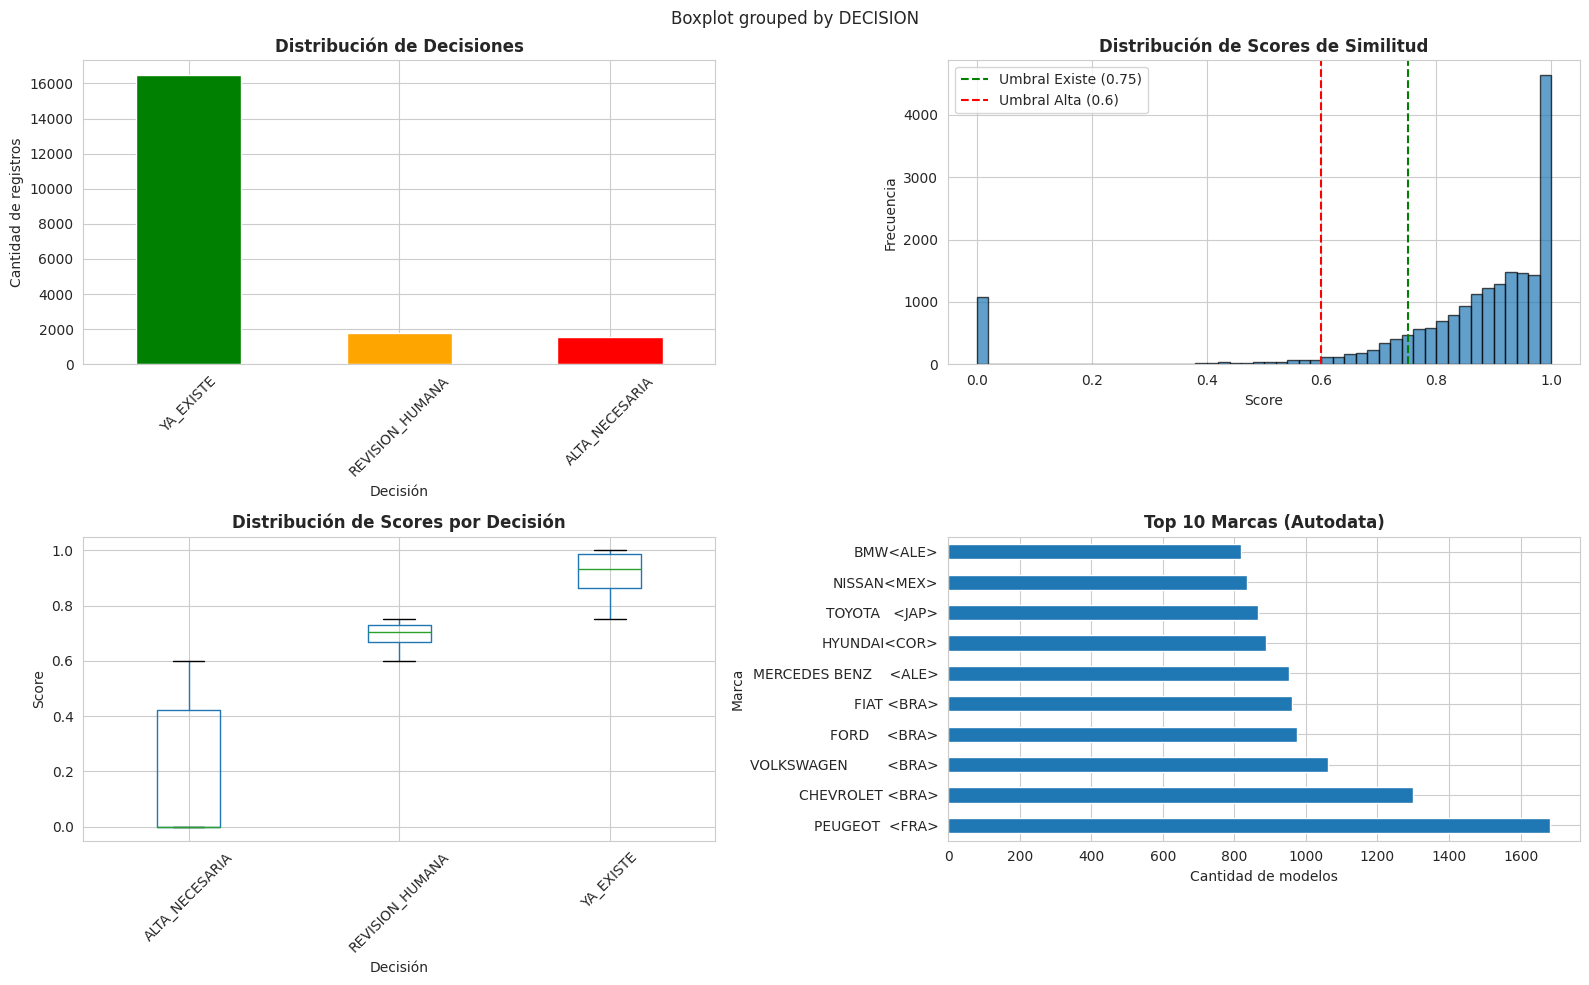

Gráficos generados y guardados como 'analisis_matching.png'


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Crear figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Análisis de Resultados - Matching BSE vs Autodata', fontsize=16, fontweight='bold')

# 1. Distribución de decisiones
decisiones_conteo.plot(kind='bar', ax=axes[0, 0], color=['green', 'orange', 'red'])
axes[0, 0].set_title('Distribución de Decisiones', fontweight='bold')
axes[0, 0].set_xlabel('Decisión')
axes[0, 0].set_ylabel('Cantidad de registros')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Histograma de scores
scores_completos = df_resultados['SCORE_MEJOR'].fillna(0)
axes[0, 1].hist(scores_completos, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=UMBRAL_EXISTE, color='green', linestyle='--', label=f'Umbral Existe ({UMBRAL_EXISTE})')
axes[0, 1].axvline(x=UMBRAL_ALTA, color='red', linestyle='--', label=f'Umbral Alta ({UMBRAL_ALTA})')
axes[0, 1].set_title('Distribución de Scores de Similitud', fontweight='bold')
axes[0, 1].set_xlabel('Score')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].legend()

# 3. Boxplot de scores por decisión
df_resultados.boxplot(column='SCORE_MEJOR', by='DECISION', ax=axes[1, 0])
axes[1, 0].set_title('Distribución de Scores por Decisión', fontweight='bold')
axes[1, 0].set_xlabel('Decisión')
axes[1, 0].set_ylabel('Score')
plt.sca(axes[1, 0])
plt.xticks(rotation=45)

# 4. Top 10 marcas con más registros
top_marcas = df_resultados['MARCA_A'].value_counts().head(10)
top_marcas.plot(kind='barh', ax=axes[1, 1])
axes[1, 1].set_title('Top 10 Marcas (Autodata)', fontweight='bold')
axes[1, 1].set_xlabel('Cantidad de modelos')
axes[1, 1].set_ylabel('Marca')

plt.tight_layout()
plt.savefig('analisis_matching.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gráficos generados y guardados como 'analisis_matching.png'")

## 1️⃣4️⃣ (OPCIONAL) Ajustar umbrales interactivamente

In [27]:
def reclasificar_con_umbrales(df, umbral_existe, umbral_alta):
    """
    Reclasifica los resultados con nuevos umbrales sin volver a ejecutar matching.
    """
    df_nuevo = df.copy()

    def nueva_decision(score):
        if pd.isna(score) or score == 0:
            return 'ALTA_NECESARIA'
        elif score >= umbral_existe:
            return 'YA_EXISTE'
        elif score < umbral_alta:
            return 'ALTA_NECESARIA'
        else:
            return 'REVISION_HUMANA'

    df_nuevo['DECISION'] = df_nuevo['SCORE_MEJOR'].apply(nueva_decision)

    # Mostrar nuevo resumen
    print(f"\nNUEVO RESUMEN (Existe > {umbral_existe}, Alta < {umbral_alta})")
    print("="*70)

    nuevo_conteo = df_nuevo['DECISION'].value_counts()
    total = len(df_nuevo)

    for decision, count in nuevo_conteo.items():
        porcentaje = (count / total) * 100
        simbolo = {'YA_EXISTE': '✅', 'ALTA_NECESARIA': '🆕', 'REVISION_HUMANA': '⚠️'}.get(decision, '❓')
        print(f"{simbolo} {decision:20s}: {count:6,} ({porcentaje:5.2f}%)")

    return df_nuevo

# Ejemplo: probar con umbrales más conservadores
print("Probando umbrales alternativos...\n")

print("\n" + "="*70)
print("OPCIÓN 1: Umbrales CONSERVADORES")
df_conservador = reclasificar_con_umbrales(df_resultados, umbral_existe=0.85, umbral_alta=0.50)

print("\n" + "="*70)
print("OPCIÓN 2: Umbrales AGRESIVOS")
df_agresivo = reclasificar_con_umbrales(df_resultados, umbral_existe=0.65, umbral_alta=0.55)


Probando umbrales alternativos...


OPCIÓN 1: Umbrales CONSERVADORES

NUEVO RESUMEN (Existe > 0.85, Alta < 0.5)
✅ YA_EXISTE           : 13,159 (66.30%)
⚠️ REVISION_HUMANA     :  5,411 (27.26%)
🆕 ALTA_NECESARIA      :  1,277 ( 6.43%)

OPCIÓN 2: Umbrales AGRESIVOS

NUEVO RESUMEN (Existe > 0.65, Alta < 0.55)
✅ YA_EXISTE           : 17,974 (90.56%)
🆕 ALTA_NECESARIA      :  1,384 ( 6.97%)
⚠️ REVISION_HUMANA     :    489 ( 2.46%)
